# Task 2: Backpropagation, Gradient descent and training <br/> CC6204 Deep Learning, Universidad de Chile  <br/>
## Name: Humberto Rodrigues 

In [14]:
import numpy as np
import torch
import torch.nn as nn

# Autocorrect library
!pip install -U "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"
from timeit import default_timer as timer

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-z5h8bc0n/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-z5h8bc0n/cc6204
  Created wheel for cc6204: filename=cc6204-0.3.2-cp36-none-any.whl size=4708 sha256=3f1be047602d2e347903841cde483027064485751ccf863b26685e0ece463009
  Stored in directory: /tmp/pip-ephem-wheel-cache-pojql6pr/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204
  Found existing installation: cc6204 0.3.2
    Uninstalling cc6204-0.3.2:
      Successfully uninstalled cc6204-0.3.2


In [15]:
# Setting-up auto-correct utility
from cc6204 import AutoCorrect, FailedTest

corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)
token = "]ye/Ox;nsz"

Connection stablished


# Part 1: Activation and Loss functions


## 1a) Derivating activation functions:
The first step we need to make is to define the form of the derivative expression for each activation function we will be testing.

*   ### Relu: 
  Analyzing the definition of this activation function we noticed that it's corresponding derivative expression is trivial and should be created as a `piecewise function` like `Relu` itself. 

  * **Function Definition**:

    \begin{equation}
      \text{relu}(x) = 
        \begin{cases}
           \text{x if x} \geq0 \\
          0 \text{ otherwise.} \\ 
        \end{cases}
    \end{equation}

  * **Derivative Expression**:

    \begin{equation}
      \frac{\partial\ \text{relu}(x)}{\partial x} = 
        \begin{cases}
          1 \text{ if x} \geq0 \\
          0 \text{ otherwise.} \\ 
        \end{cases}
    \end{equation}
<br>

*   ### Swish:
  In this case it is important to notice that `swish` is defined in terms of `sigmoid` function and we will be using that to create a more compact derivative expression but it also implies that we will need to calculate the derivative expression for sigmoid as well.

  * **Function Definitions**:

    \begin{equation}
      \text{sigmoid}(\beta x) = \frac{1}{1 + e^{- \beta x}} 
    \end{equation}

    \begin{equation}
      \text{swish}(x,\beta) = x \cdot sigmoid(\beta x) 
    \end{equation}

  The idea behind adding $ \beta $ as a parameter instead of using a fixed value is estimate a good value for it with the model we will be creating.

  * **Derivative Expression**:

      The first thing is estimate the corresponding derivative expression for sigmoid which is: 

     <br>

      \begin{equation}
        \frac{\partial\ \text{sigmoid}(\beta x)}{\partial x} = \frac{\beta e^{- \beta x}}{(1 + e^{- \beta x})^2}
      \end{equation}

     From here we will apply some mathematic tricks like adding and substracting one to simplify this expresion and get a result in terms of sigmoid itself.

      \begin{equation}
        \frac{\beta e^{- \beta x}}{(1 + e^{- \beta x})^2} = \frac{\beta}{(1 + e^{- \beta x})} \cdot \frac{1 + e^{- \beta x} - 1 }{(1 + e^{- \beta x})}
        = \frac{\beta}{(1 + e^{- \beta x})} \cdot (1 - \frac{1}{(1+e^{- \beta x})})
      \end{equation}

      Now we can see that the `left` part of the expression is equivalent to $\beta \cdot sigmoid(\beta x) $ and the `right` part it can be written like $1 - sigmoid(\beta x) $ so the final derivative expressions for sigmoid we will be using are: 

      <br>sigmoid(\beta x) + \beta \cdot swish(\beta x) \cdot (1 - sigmoid(\beta x)))
      \begin{equation}
        \frac{\partial\ \text{sigmoid}(\beta x)}{\partial x} = \beta \cdot sigmoid(\beta x) \cdot (1 - sigmoid(\beta x))
      \end{equation}

      <br>
      \begin{equation}
        \frac{\partial\ \text{sigmoid}(\beta x)}{\partial \beta} = x \cdot sigmoid(\beta x) \cdot (1 - sigmoid(\beta x))
      \end{equation}
      <br>

      Finally we can express the derivative expressions for `swish`  using the `derivative product rule` as:

      \begin{equation}
        \frac{\partial\ \text{swish}(x,\beta)}{\partial x} = x' \cdot sigmoid(\beta x) + x \cdot sigmoid(\beta x)'
      \end{equation}

      \begin{equation}
        \frac{\partial\ \text{swish}(x,\beta)}{\partial x} = sigmoid(\beta x) + x \cdot (\beta \cdot sigmoid(\beta x) \cdot (1 - sigmoid(\beta x)))
      \end{equation}

      <br>

      \begin{equation}
        \frac{\partial\ \text{swish}(x,\beta)}{\partial x} = swish(x,\beta) \cdot (\frac{1}{x \cdot \beta} + 1 - \frac{swish(x,\beta)}{x} )
      \end{equation}
      
      And the derivative expression for `swish` in terms of $\beta$ will be:

      <br>

      \begin{equation}
        \frac{\partial\ \text{swish}(x,\beta)}{\partial \beta} = x^{2} \cdot ( sigmoid(\beta x) \cdot (1 - sigmoid(\beta x))
      \end{equation}
      
      <br>
      
      \begin{equation}
        \frac{\partial\ \text{swish}(x,\beta)}{\partial \beta} = swish(x,\beta) \cdot (x - swish(x,\beta))
      \end{equation}


      
      
 *   ### CELU:
  This case is pretty similiar to the `RELU` we will be expressing `CELU` as a 
 `piecewise function` and it is respective derivative function will be the same as well:
  <br>

  * **Function Definition**:

    \begin{equation}
      \text{celu}(x,\alpha) = 
        \begin{cases}
          \text{x if x} \geq0 \\
          \alpha \cdot (e^{\frac{x}{\alpha}} - 1) \text{ otherwise.} \\ 
        \end{cases}
    \end{equation}

  * **Derivative Expression**:

    \begin{equation}
      \frac{\partial\ \text{celu}(x,\alpha)}{\partial x} = 
        \begin{cases}
          1 \text{ if x} \geq0 \\
          e^{\frac{x}{\alpha}} \text{ otherwise.} \\ 
        \end{cases}
    \end{equation}

    <br>

    \begin{equation}
      \frac{\partial\ \text{celu}(x,\alpha)}{\partial \alpha} = 
        \begin{cases}
          0 \text{ if x} \geq0 \\
          e^{\frac{x}{\alpha}} \cdot (1 - \frac{x}{\alpha}) - 1 \text{ otherwise.} \\ 
        \end{cases}
    \end{equation}



## 1a-2) Implementing Derivative expressions:

In [16]:
# This is the most common approach to implement the derivative expressions
# the gradient parameter is use to determine if should be evaluated
# the function itself or it's corresponding derivative

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

def tanh_dx(T):
  return 1 - tanh(T)^2

def softmax(T, dim=1, stable=True):
  maxes = torch.max(T, dim, keepdim=True)[0] if stable else 0
  x_exp = torch.exp(T-maxes)
  x_exp_sum = torch.sum(x_exp, dim, keepdim=True)
  return x_exp/x_exp_sum

def relu(T):
  return torch.max(T,torch.zeros(T.size(),device=T.device))

def swish(T, beta=1.0):
  return T * sig(beta * T)

def celu(T, alpha=1.0):
  zero_T = torch.zeros(T.size(),device=T.device)
  return torch.max(T,zero_T) + torch.min(alpha * (torch.exp(T/alpha) - 1),zero_T)


def sig(T, gradient=False):
  if gradient:
    sigT = sig(T)
    return sigT * (1 - sigT)
  return torch.reciprocal(1 + torch.exp(-1 * T))

def relu_dx(T):
  X = T.clone()
  X[X >= 0] = 1
  X[X < 0] = 0
  return X

def swish_dx(T, beta=1.0):
  X = T.clone()
  sig_bx = sig(beta*X)
  return sig_bx + beta * X * sig_bx * (1 - sig_bx)


def swish_db(T, beta=1.0):
  X = T.clone()
  sig_bx = sig(beta*X)
  return  X * X * sig_bx * (1 - sig_bx)
       
 
def celu_dx(T, alpha=1.0):
  X = T.clone()
  X[X >= 0] = 0
  x_alpha = X[X < 0] / alpha
  X[X < 0] = torch.exp(x_alpha)
  return X
                      
def celu_da(T, alpha=1.0):
  X = T.clone()
  X[X >= 0] = 0
  x_alpha = X[X < 0] / alpha
  X[X < 0] = (torch.exp(x_alpha) * (1 - x_alpha)) - 1
  return X

activation_dx = {"relu": relu_dx, "celu": celu_dx, "swish": swish_dx}
activation_dp = {"celu": celu_da, "swish": swish_db}

## 1b) Implementing Cross Entropy Loss


In [17]:
def CELoss(Q, P, estable=True, epsilon=1e-8):
  if estable:
    Q[Q < epsilon] = epsilon
  return torch.mean(-torch.sum(P*torch.log(Q),-1))

In [18]:
# Tests del API del curso
for test in ['small', 'estable', 'eps', 'no-estable']:
  # Obtengamos dos distribuciones de probabilidad y los parametros estable y epsilon
  Q, P, estable, eps = corrector.get_test_data(homework=2, question="1b", test=test, token=token)
  # Corramos tu implementacion de CELoss para ver como se comporta
  s = timer()
  result = CELoss(Q=torch.Tensor(Q), P=torch.Tensor(P), estable=estable, epsilon=eps)
  t = timer() - s
  corrector.sumbit(homework=2, question="1b", test=test, token=token, answer=result, time=0)

Using cached test data
Correct Test!
Using cached test data
Correct Test!
Using cached test data
Correct Test!
Using cached test data
Correct Test!


# Part 2: More derivatives expressions

## 2a) Calculating derivative expressions
The first thing we need to do is calculate how we will be propagating the error obtained in our `loss` function to every parameter of our neural network. This will be done using the backpropagation algorithm which consist basically in pass the error from the last layer of our model to the first of them going layer by layer and modifying each parameter depending on how much of the result is affected by it.

To be able to apply this method we will need to calculate the corresponding derivative expression for our `loss` function in terms of all the parameters of our model using the derivative chain rule.

Before starting the calculation of the derivative expressions we will need to make some definitions that will be useful in this task.
<br>


$$u^{(L+1)} = h^{(L)} U + c$$

$$\hat{y} = softmax(u^{(L+1)})$$

<br>

it is possible to notice that we are using `softmax` as the output function for this reason the first step we will do is estimate the derivative expressions for it and use them as definitions in the future steps.

<br>

\begin{equation}
\frac{\partial x_i}{\partial x_j} = \frac{(\frac{\partial e^{x_i}}{\partial x_j} \cdot \sum_k{e^{x_k}}) - (e^{x_i} \cdot \frac{\partial \sum_k{e^{x_k}}}{\partial x_j})}{(\sum_k{e^{x_k}})^2}
\end{equation}



As we can see in that general derivative expression of softmax we will have two possible scenarios:

* Scenario $i=j$, then we can simplify 

  \begin{equation}
  \frac{\partial x_i}{\partial x_i} = \frac{(\frac{\partial e^{x_i}}{\partial x_i} \cdot \sum_k{e^{x_k}}) - (e^{x_i} \cdot \frac{\partial \sum_k{e^{x_k}}}{\partial x_i})}{(\sum_k{e^{x_k}})^2}
  \end{equation}

  \begin{equation}
  \frac{\partial x_i}{\partial x_i} = \frac{(e^{x_i} \cdot \sum_k{e^{x_k}}) - (e^{x_i} \cdot e^{x_i})}{(\sum_k{e^{x_k}})^2}
  \end{equation}

  \begin{equation}
  \frac{\partial x_i}{\partial x_i} = \frac{e^{x_i} \cdot ( \sum_k{e^{x_k}} - e^{x_i})}{(\sum_k{e^{x_k}})^2}
  \end{equation}

  <br>
  \begin{equation}
  \frac{\partial x_i}{\partial x_i} = \frac{e^{x_i}}{\sum_k{e^{x_k}}} \cdot \frac{( \sum_k{e^{x_k}} - e^{x_i})}{\sum_k{e^{x_k}}}
  \end{equation}

  \begin{equation}
  \frac{\partial x_i}{\partial x_i} = \frac{e^{x_i}}{\sum_k{e^{x_k}}} \cdot \frac{\sum_k{e^{x_k}} \cdot (1 - \frac{e^{x_i}}{\sum_k{e^{x_k}}})}{\sum_k{e^{x_k}}}
  \end{equation}

  \begin{equation}
  \frac{\partial x_i}{\partial x_i} = \frac{e^{x_i}}{\sum_k{e^{x_k}}} \cdot (1 - \frac{e^{x_i}}{\sum_k{e^{x_k}}})
  \end{equation}

  <br>
  And this expression can be interpreted as:
  \begin{equation}
  \frac{\partial x_i}{\partial x_i} = softmax(x_i) \cdot (1 - softmax(x_i))
  \end{equation}

  <br>
* Scenario $i \neq j$, we can simplify  

  <br>

  \begin{equation}
  \frac{\partial x_i}{\partial x_j} = \frac{(0 \cdot \sum_k{e^{x_k}}) - (e^{x_i} \cdot e^{x_j})}{(\sum_k{e^{x_k}})^2}
  \end{equation}

  \begin{equation}
  \frac{\partial x_i}{\partial x_j} = \frac{-e^{x_i} \cdot e^{x_j}}{(\sum_k{e^{x_k}})^2}
  \end{equation}

  \begin{equation}
  \frac{\partial x_i}{\partial x_j} = \frac{-e^{x_i}}{\sum_k{e^{x_k}}} \cdot \frac{e^{x_j}}{\sum_k{e^{x_k}}}
  \end{equation}

  Now we can express the last equation in terms of softmax as we did with the previous case:

  <br>
  \begin{equation}
  \frac{\partial x_i}{\partial x_j} = -softmax(x_i) \cdot softmax(x_j)
  \end{equation}

<br>

Finally we can express the derivative expression of $\cal L$ in terms of $u^{(L+1)}$ using the derivative rule of chain as follows:

<br>

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}} = \frac{\partial \cal L}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial u^{(L+1)}}
\end{equation}

As we explored before, softmax has two different derivative expressions that apply in two distinct scenarios for this reason we will be doing some matemathic tricks to use the right one depending on the case:

The first thing is that based on `Einstein notation` we will be adding some sub indexes to all well known dimension:

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}}_{b,j} = \frac{\partial \cal L}{\partial \hat{y}_{b}} \cdot \frac{\partial \hat{y}_{b}}{\partial u^{(L+1)}}_{b,j}
\end{equation}

<br>

Now we will express the derivative of $\cal L$ in terms of $\hat{y}_b$. For this we will be using the definition of our **Cross Entropy Loss** and calculate his derivative expression. It is important to notice that the $\hat{y}$ is a tensor of dimension (B,C) but we are only adding one sub index to it because the second one will be use to split the cases of the softmax.

<br>

\begin{equation}
\frac{\partial \cal L}{\partial \hat{y}
} = \frac{\partial -\frac{1}{N} \cdot (\sum_k^N{\sum_i^C{y_{ki} \cdot log(\hat{y}_{ki})}})}{\partial \hat{y}}
\end{equation}

we can remove external summatory based on $k$ because will only be different than 0 when $k=b$.

\begin{equation}
\frac{\partial \cal L}{\partial \hat{y}_b} = \frac{\partial -\frac{1}{N} \cdot \sum_i^C{y_{bi} \cdot log(\hat{y}_{bi})}}{\partial \hat{y_b}}
\end{equation}

<br>

Now we will extract from the summatory the case where $i = j$:

<br>

\begin{equation}
\frac{\partial \cal L}{\partial \hat{y}_b} = \frac{\partial -\frac{1}{N} \cdot \sum_{i \neq j}^C{y_{bi} \cdot log(\hat{y}_{bi})} - y_{bj} \cdot log(\hat{y}_{bj})} {\partial \hat{y_b}}
\end{equation}

\begin{equation}
\frac{\partial \cal L}{\partial \hat{y}_b} = -\frac{1}{N} \cdot \sum_{i \neq j}^C{\frac{y_{bi} }{\hat{y}_{bi}}} - \frac{y_{bj}}{\hat{y}_{bj}}
\end{equation}

<br>
 
 Notice that if we keep derivating the $\hat{y}_{bi}$ and $\hat{\hat{y}}_{bj}$ applying the chain rule what we will obtain is in fact our goal which is:
$\frac{\partial \cal L}{\partial u^{(L+1)}}_{b,j}$

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}}_{b,j} = -\frac{1}{N} \cdot \sum_{i \neq j}^C{\frac{y_{bi} }{\hat{y}_{bi}} \cdot \frac{\partial \hat{y}_{bi}} {\partial u^{(L+1)}}_{b,j}} - \frac{y_{bj}}{\hat{y}_{bj}} \cdot \frac{\partial \hat{y}_{bj}} {\partial u^{(L+1)}}_{b,j}
\end{equation}

In this step we can notice that each one of the derivative expressions we need to calculate for $\hat{y}$ corresponds to the two different cases of the softmax we detailed before, replacing that obtained expressions in terms of our current equation resulting in:

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}}_{b,j} = -\frac{1}{N} \cdot \sum_{i \neq j}^C{(\frac{y_{bi} }{\hat{y}_{bi}} \cdot - \hat{y}_{bi} \cdot \hat{y}_{bj}) } - (\frac{y_{bj}}{\hat{y}_{bj}} \cdot \hat{y}_{bj} \cdot (1 - \hat{y}_{bj})) 
\end{equation}

From here we need to simplify the expression in a way is easy and afficient to compute

<br>

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}}_{b,j} = -\frac{1}{N} \cdot \sum_{i \neq j}^C{-(y_{bi} \cdot \hat{y}_{bj}) } - (y_{bj} \cdot (1 - \hat{y}_{bj})) 
\end{equation}


\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}}_{b,j} = -\frac{1}{N} \cdot \sum_{i \neq j}^C{-(y_{bi} \cdot \hat{y}_{bj}) } - y_{bj} - (y_{bj} \cdot \hat{y}_{bj})
\end{equation}

The next step is to put back the case where $ i = j $ into our summatory

\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}}_{b,j} = -\frac{1}{N} \cdot \sum_{i}^C{-y_{bi} \cdot \hat{y}_{bj} } - y_{bj}
\end{equation}

We can see that $-\hat{y_{bj}}$ is not depending on the summatory so we can take it out


\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}}_{b,j} = \frac{1}{N} \cdot (\hat{y}_{bj} \cdot \sum_{i}^C{y_{bi} } - y_{bj})
\end{equation}


Finally $\sum_{i}^C{y_{bi} }$ is a probability distribution which total sum value is $1$ and returning back the `Einstein notation` we get:


\begin{equation}
\frac{\partial \cal L}{\partial u^{(L+1)}} = \frac{\hat{y}- y}{N}
\end{equation}



## 2b) Derivating the rest of the last layer

<br>

\begin{equation}
\frac{\partial\cal L}{\partial U} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot \frac{\partial u^{(L+1)} }{\partial U}
\end{equation}

The first step as always is setup `Einstein Notation`

\begin{equation}
\frac{\partial\cal L}{\partial U_{ij}} = \frac{\partial \cal L}{\partial u_{ab}^{(L+1)}} \cdot \frac{\partial u_{ab}^{(L+1)} }{\partial U_{ij}}
\end{equation}

We replace using the definition of $u_{ab}^{(L+1)}$


\begin{equation}
\frac{\partial\cal L}{\partial U_{ij}} = \frac{\partial \cal L}{\partial u_{ab}^{(L+1)}} \cdot \frac{\partial h_{ak}^{(L)} U_{kb} + c }{\partial U_{ij}} 
\end{equation}

Then we noticed that the only expression different than 0 is when $k=i, b=j$

\begin{equation}
\frac{\partial\cal L}{\partial U_{ij}} = \frac{\partial \cal L}{\partial u_{aj}^{(L+1)}} \cdot \frac{\partial h_{ai}^{(L)} U_{ij} + c }{\partial U_{ij}}
\end{equation}


\begin{equation}
\frac{\partial\cal L}{\partial U_{ij}} = \frac{\partial \cal L}{\partial u_{aj}^{(L+1)}} \cdot h_{ai}^{(L)}
\end{equation}

Analyzing the indexes $j, i$ we can notice that we need to apply some transformation to $h_{ai}^{(L)}$  before be able to multiply by the rest of the expression. This transformation is nothing more than a transposition in it is dimensions.

\begin{equation}
\frac{\partial\cal L}{\partial U_{ij}} = (h_{ai}^{(L)})^T \cdot \frac{\partial \cal L}{\partial u_{aj}^{(L+1)}}
\end{equation}

Finally we just revert `Einstein Notation`

\begin{equation}
\frac{\partial\cal L}{\partial U} = (h^{(L)})^T \cdot \frac{\partial \cal L}{\partial u^{(L+1)}}
\end{equation}

<br>

---
<br>

\begin{equation}
\frac{\partial\cal L}{\partial c} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot \frac{\partial u^{(L+1)} }{\partial c} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot \frac{\partial h^{(L)} U + c }{\partial c} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot 1 (\text{tensor}) = Sum(\frac{\partial \cal L}{\partial u^{(L+1)}})
\end{equation}

<br>

---

<br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(L)}} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot \frac{\partial u^{(L+1)} }{\partial h^{(L)}} 
\end{equation}


\begin{equation}
\frac{\partial\cal L}{\partial h_{ij}^{(L)}} = \frac{\partial \cal L}{\partial u_{a}^{(L+1)}} \cdot \frac{\partial u_{a}^{(L+1)} }{\partial h_{ij}^{(L)}} 
\end{equation}

\begin{equation}
\frac{\partial\cal L}{\partial h_{ij}^{(L)}} = \frac{\partial \cal L}{\partial u_{a}^{(L+1)}} \cdot \frac{\partial h_{ab}^{(L)} U_{b} + c  }{\partial h_{ij}^{(L)}} 
\end{equation}

In this moment we can clearly see that the only expression different than 0 are 
when $a=i,  b=j$

\begin{equation}
\frac{\partial\cal L}{\partial h_{ij}^{(L)}} = \frac{\partial \cal L}{\partial u_{i}^{(L+1)}} \cdot \frac{\partial h_{ij}^{(L)} U_{j} + c  }{\partial h_{ij}^{(L)}} 
\end{equation}

\begin{equation}
\frac{\partial\cal L}{\partial h_{ij}^{(L)}} = \frac{\partial \cal L}{\partial u_{i}^{(L+1)}} \cdot  U_{j} 
\end{equation}

We can see what we have is a tensorial product, the particular thing about this operation is that is not actually implemented in pytorch but can be simulated if we "change" the form of the tensor U which has dimension (D3,D2) to (D2,D3), doing this we can apply a normal matricial multiplication between $\frac{\partial \cal L}{\partial u_{i}^{(L+1)}}$ and $ (U_{j})^T $. It is also important to notice that the dimensions of $u_{i}^{(L+1)}$ are (D1,D2) Finally the result of this operation will have dimensions (D1,D3)

\begin{equation}
\frac{\partial\cal L}{\partial h^{(L)}} = \frac{\partial \cal L}{\partial u^{(L+1)}} \cdot  (U)^T 
\end{equation}

<br>

## 2c) Derivating hidden layers

<br>
In this step we will be derivating $\frac{\partial\cal L}{\partial u^{(k)}}$ for each one of the activation functions we detailed before, it is also necessary to assume that $\frac{\partial\cal L}{\partial h^{(k)}}$ it is already calculated at this point:

* Relu:

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}} = \frac{\partial\cal L}{\partial h^{(k)}} \cdot \frac{\partial h^{(k)}}{\partial u^{(k)}}
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}}_{ij} = \frac{\partial\cal L}{\partial h^{(k)}}_{ab} \cdot \frac{\partial h^{(k)}_{ab}}{\partial u^{(k)}_{ij}} = \frac{\partial\cal L}{\partial h^{(k)}}_{ij} \cdot \frac{ \partial relu(u^{(k)}_{ij}) }{\partial u^{(k)}_{ij}} = \frac{\partial\cal L}{\partial h^{(k)}}_{ij} \cdot \cal K_{ij} 
\begin{cases}
  1 \text{ if } u_{ij} \geq0 \\
  0 \text{ otherwise.} \\ 
\end{cases}
\end{equation}


---

* Celu: In the specific case of this function we will be calling $\alpha^{k}$ the parameter stored in our model that will be used for the expected `CELU` activation function in the layer $k$

<br>

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}}_{ij} = \frac{\partial\cal L}{\partial h^{(k)}}_{ab} \cdot \frac{\partial h^{(k)}_{ab}}{\partial u^{(k)}_{ij}} = \frac{\partial\cal L}{\partial h^{(k)}}_{ij} \cdot \frac{ \partial celu(u^{(k)}_{ij}, \alpha^{k}) }{\partial u^{(k)}_{ij}} = \frac{\partial\cal L}{\partial h^{(k)}}_{ij} \cdot \cal K_{ij} 
\begin{cases}
  1 \text{ if } u_{ij} \geq0 \\ 
  e^{\frac{x}{\alpha}} \text{ otherwise.} \\ 
\end{cases}
\end{equation}

<br>

Now we need to calculate $\frac{\partial\cal L}{\partial \alpha^k}$ we will write it as well in terms of the chain rule as follows:

\begin{equation}
\frac{\partial\cal L}{\partial \alpha^k} = \frac{\partial\cal L}{\partial h^{(k)}} \cdot \frac{\partial h^{(k)}}{\partial \alpha^k}
\end{equation}

\begin{equation}
\frac{\partial\cal L}{\partial \alpha^k} = \frac{\partial\cal L}{\partial h^{(k)}} \cdot \frac{\partial celu(u^k,\alpha^k)}{\partial \alpha^k}
\end{equation}

\begin{equation}
\frac{\partial\cal L}{\partial \alpha^k} = \frac{\partial\cal L}{\partial h^{(k)}_{ij}} \cdot \frac{\partial celu(u^k_{ij},\alpha^k)}{\partial \alpha^k}
\end{equation}

\begin{equation}
\frac{\partial\cal L}{\partial \alpha^k} = \frac{\partial\cal L}{\partial h^{(k)}_{ij}} \cdot \cal K_{ij}
\begin{cases}
  0 \text{ if } u_{ij} \geq0 \\
  e^{\frac{u_{ij}}{\alpha}} \cdot (1 - \frac{u_ij}{\alpha}) - 1 \text{ otherwise.}
\end{cases}
\end{equation}

---

* Swish

<br>

\begin{equation}
\frac{\partial\cal L}{\partial u^{(k)}}_{ij} = \frac{\partial\cal L}{\partial h^{(k)}}_{ab} \cdot \frac{\partial h^{(k)}_{ab}}{\partial u^{(k)}_{ij}} = \frac{\partial\cal L}{\partial h^{(k)}}_{ij} \cdot \frac{ \partial swish(u^{(k)}_{ij}, \beta^{k}) }{\partial u^{(k)}_{ij}} = \frac{\partial\cal L}{\partial h^{(k)}}_{ij} \cdot swish(u^{(k)}_{ij},\beta) \cdot (\frac{1}{u^{(k)}_{ij} \cdot \beta} + 1 - \frac{swish(u^{(k)}_{ij},\beta)}{u^{(k)}_{ij}} )
\end{equation}


<br>

Now we need to calculate $\frac{\partial\cal L}{\partial \beta^k}$ we will write it as well in terms of the chain rule as follows:

\begin{equation}
\frac{\partial\cal L}{\partial \beta^k} = \frac{\partial\cal L}{\partial h^{(k)}} \cdot \frac{\partial h^{(k)}}{\partial \beta^k}
\end{equation}

\begin{equation}
\frac{\partial\cal L}{\partial \beta^k} = \frac{\partial\cal L}{\partial h^{(k)}} \cdot \frac{\partial swish(u^k,\beta^k)}{\partial \beta^k}
\end{equation}

\begin{equation}
\frac{\partial\cal L}{\partial \beta^k} = \frac{\partial\cal L}{\partial h^{(k)}} \cdot swish(u^k,\beta^k) \cdot (u^k - swish(u^k,\beta^k))
\end{equation}



---

This section is no more than the generalization of the previous derivative expressions we calculated for the output layer:


<br>

\begin{equation}
\frac{\partial\cal L}{\partial W^{(k)}} = (h^{k-1})^T \cdot \frac{\partial \cal L}{u^k}
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial b^{(k)}} = Sum(\frac{\partial \cal L}{\partial u^{(k)}})
\end{equation}
<br>

\begin{equation}
\frac{\partial\cal L}{\partial h^{(k-1)}} = \frac{\partial \cal L}{\partial u^{(k)}} \cdot  (W^k)^T 
\end{equation}
<br>

# Part 3: Backpropagation 

In [20]:
class FFNN(torch.nn.Module):
  def create_extra_parameters(self, extra):
    if extra:
      res = []
      for p in extra:
        if p:
          res.append(nn.Parameter(torch.tensor(p)))
        else:
          res.append(nn.Parameter(None))
      self.extra_params = nn.ParameterList(res)
    else:
      self.extra_params = None

  def create_parameters(self, h_l, l_a, C, extra=None,initial_weights=None):
    internal_layers = []
    internal_biases = []
    for i in range(0, len(h_l)-1):
      if initial_weights:
        # The structure with initial weights for the `lth` layer will be (W,b)
        # We need to ensure that the dimensions of the data MATCH with the model
        current_weights = initial_weights[i][0]
        current_bias = initial_weights[i][1]
        if len(current_weights) != h_l[i] or len(current_weights[0]) != h_l[i+1] or len(current_bias) != h_l[i+1]:
          raise Exception("Dimension mismatch")
        else:
          internal_layers.append(nn.Parameter(current_weights))
          internal_biases.append(nn.Parameter(current_bias))
      else:
        internal_layers.append(nn.Parameter(torch.randn(h_l[i],h_l[i+1])))
        internal_biases.append(nn.Parameter(torch.zeros(h_l[i+1])))

    self.h_weights = nn.ParameterList(internal_layers)
    self.biases = nn.ParameterList(internal_biases)
    self.activation_functions = l_a[:-1]

    self.create_extra_parameters(extra)

    # Output Layer, bias (c), and softmax 
    # It is important to notice the use of ParameterList also for this layer
    # This is because the nn.Parameter directly is not being reflected in the 
    # print(model) method and that is the one being used for the summary 

    if initial_weights:
      # Is expected that the last position of `initial_weights` is (U,c)
      output_weights = initial_weights[-1][0]
      output_bias = initial_weights[-1][1]

      if len(output_weights) != h_l[-1] or len(output_weights[0]) != C or len(output_bias) != C:
          raise Exception("Dimension mismatch")
      else:
        self.output_weights = nn.ParameterList([nn.Parameter(output_weights)])
        self.output_bias = nn.ParameterList([nn.Parameter(output_bias)])
    else:
      self.output_weights = nn.ParameterList([nn.Parameter(torch.randn(h_l[-1],C))])
      self.output_bias = nn.ParameterList([nn.Parameter(torch.zeros(C))])
    self.output_function = l_a[-1]

  def __init__(self, F, l_h, l_a, C, extra=None, initial_weights=None):
    super(FFNN, self).__init__()
    
    if len(l_h)+1 != len(l_a):
      raise Exception("Dimension mismatch")
    if extra and len(extra) != len(l_a):
      raise Exception("Dimension mismatch")
    if initial_weights and len(initial_weights) != (len(l_h) + 1):
      print(len(initial_weights),(len(l_h) + 1))
      raise Exception("Dimension mismatch")

    self.create_parameters([F]+l_h,l_a,C,extra,initial_weights)
  
  def summary(self):
    
    # In this case the summary is being show using the string method defined in the class
    # because is easy to see the details of all the internal parameters
    # also the use of this string method is the reason of addding output weights
    # as a paremetertList to be able to see it Listed here. 

    print(f"#######MODEL SUMMARY#######\n")
    print(f"Input Layer size: {self.h_weights[0].size()[0]}\n")
    print("Internal params detail:")
    print(f"{self}")
    print(f"Activation Functions{[f.__name__ for f in self.activation_functions+[self.output_function]]}\n")
    print(f"Output Layer size: {self.output_weights[0].size()[1]}\n")
    print(f"Total trainable Parameters: { sum(p.numel() for p in self.parameters() if p.requires_grad)}")
    print(f"Total Parameters: { sum(p.numel() for p in self.parameters())}\n")
    print(f"########SUMMARY END########\n\n")
  
  def forward(self, x):
    cache = {"hs":[], "us":[] }
    for i in range(0, len(self.h_weights)):
      # Validation to retrieve the possible extra params for the i_th activation function
      current_extras = [self.extra_params[i]] if self.extra_params and not self.extra_params[i].nelement() == 0 else []

      u = x @ self.h_weights[i] + self.biases[i]

      # x = h for practical effects we are just updating the input variable
      x = self.activation_functions[i](u,*current_extras)
      cache["hs"].append(x)
      cache["us"].append(u)
    self.cache = cache

    # Validation to retrieve the possible extra params for the output activation function
    output_extras = [self.extra_params[-1].data] if self.extra_params and not self.extra_params[-1].nelement() == 0 else []
    # print(output_extras)

    # y' = x * U + c
    x = self.output_function(torch.matmul(x,self.output_weights[0]) + self.output_bias[0],*output_extras)
    return x

  def backward(self, x, y, y_pred):
    b = x.size()[0]

    dl_du = (1/b) * (y_pred - y)
    self.output_weights[0].grad = self.cache["hs"][-1].t() @ dl_du
    self.output_bias[0].grad = torch.sum(dl_du, 0)
    current_dl_dh = dl_du @ self.output_weights[-1].t()

    for i in range(len(self.h_weights)-1,-1,-1):
      # extract extra param for activation function in layer i
      current_extras = [self.extra_params[i].data] if  self.extra_params and not self.extra_params[i].nelement() == 0 else []

      # calculating dl_du^k
      current_dl_du = current_dl_dh * activation_dx[self.activation_functions[i].__name__](self.cache["us"][i],*current_extras)

      # in case there is a trainable parameter we calculate it is grad
      if current_extras:
        
        res = torch.mean(
          torch.flatten(
            (
              current_dl_dh * activation_dp[self.activation_functions[i].__name__](self.cache["us"][i],*current_extras)
            )
          )
        )
        current_extras[0].grad = res
      # special condition to set x as the first h_i
      h_k = self.cache["hs"][i-1] if i > 0 else x
      
      # dl_dw^k
      self.h_weights[i].grad = h_k.t() @ current_dl_du
      
      #dl_db^k
      self.biases[i].grad =  torch.sum(current_dl_du, 0)

      #dl_dh^(k-1)
      current_dl_dh = current_dl_du @ self.h_weights[i].t()

In [37]:
# Running random model with random input to verify the forward it is working and the extra params as well

demo_network = FFNN(2,[3,4],[swish,swish,softmax],5,extra=[2.0,1.0,None])
demo_network.summary()
demo_input = torch.randn(25,2)
demo_output = torch.randn(25,5)
demo_network.backward(demo_input,demo_output,demo_network(demo_input))


#######MODEL SUMMARY#######

Input Layer size: 2

Internal params detail:
FFNN(
  (h_weights): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 2x3]
      (1): Parameter containing: [torch.FloatTensor of size 3x4]
  )
  (biases): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size 3]
      (1): Parameter containing: [torch.FloatTensor of size 4]
  )
  (extra_params): ParameterList(
      (0): Parameter containing: [torch.FloatTensor of size ]
      (1): Parameter containing: [torch.FloatTensor of size ]
      (2): Parameter containing: [torch.FloatTensor of size 0]
  )
  (output_weights): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 4x5])
  (output_bias): ParameterList(  (0): Parameter containing: [torch.FloatTensor of size 5])
)
Activation Functions['swish', 'swish', 'softmax']

Output Layer size: 5

Total trainable Parameters: 52
Total Parameters: 52

########SUMMARY END########




In [38]:
# Simple method to format the pre-trained weights to the accepted structure 
# basically we expect to have U and c in the last position of Ws and bs
def format_initial_weights(Ws,bs,U,c):
  new_w = Ws + [U]
  new_b = bs + [c]

  new_w = [torch.tensor(w) for w in new_w]
  new_b = [torch.tensor(b) for b in new_b]
  return list(zip(new_w,new_b))

In [39]:
# Runnig more automatic test this time for the whole model with mnist pre trained data 
for test in ['mnist-model']:
  F, l_h, l_a, C, Ws, U, bs, c, X, y = corrector.get_test_data(homework=2, question="3a", test=test, token=token)
  l_a = [f for s in l_a for f in [sig, tanh, relu, celu] if f.__name__ == s]

  # we also add the output function as the last position of the activation functions

  l_a.append(softmax)
  your_model = FFNN(F,l_h,l_a,C,initial_weights=format_initial_weights(Ws,bs,U,c))
  
  idx = next(i for i, p in enumerate(your_model.parameters()) if p.size() == torch.Tensor(Ws[1]).size() and torch.all(torch.Tensor(Ws[1])==p))

  # Testing forward
  y_pred = your_model(torch.Tensor(X))
  
  # Testing backward
  s = timer()
  your_model.backward(torch.Tensor(X), torch.Tensor(y), y_pred)
  t = timer() - s
  
  corrector.sumbit(homework=2, question="3a", test=test, token=token, 
                   answer=list(your_model.parameters())[idx].grad.mean(), time=0)

Using cached test data
Correct Test!


# Part 4: Gradient Descent and optimization

## 4a) Stochastic gradient descent

In [25]:
class SGD():
  def __init__(self, parameters, lr):
    self.parameters = parameters
    self.lr = lr
  
  def step(self):
    for p in self.parameters:
      if p.grad is not None:
        p.data -= lr * p.grad

In [40]:
# Some automatic test for the SGD class implemented
from torch.nn import Parameter
for test in ['small-step', 'big-step', 'random']:
  ds, gs, lr, idx = corrector.get_test_data(homework=2, question="4a", test=test, token=token)
  parameters = [Parameter(torch.Tensor(d)) for d in ds]
  for p, g in zip(parameters, gs):
    p.grad = torch.Tensor(g)

  optimizer = SGD(parameters, lr)

  # basically we run the step() method and we expect that the parameters change in terms of the grad
  s = timer()
  optimizer.step()
  t = timer() - s

  corrector.sumbit(homework=2, question="4a", test=test, token=token, 
                   answer=parameters[idx].data, time=0)

Using cached test data
Correct Test!
Using cached test data
Correct Test!
Using cached test data
Correct Test!


## 4b) Pseudo Random dataset
What we will be using in this test is a custom torch dataset that will be filled with random points (x, y) between -50 and 50, in addition we will have a particular line equation (can be any other) and what we will do is assign a class value to all the pairs (x,y) that are above the line and another class value for the ones below.

In [43]:
from torch.utils.data import Dataset, DataLoader

class RandomDataset(Dataset):
  def __init__(self, N, F, C):

    eval = lambda x : 2 * x -1

    x_random_data = [ torch.randint(low=-50,high=50,size=(F,)) for i in range(N)]
    
    y_data = []

    for i in range(N):
      ct = torch.zeros(C)
      c = 1 if x_random_data[i][1] > eval(x_random_data[i][0]) else 0
      ct[c] = 1
      y_data.append(ct)

    self.x_data = x_random_data
    self.y_data = y_data
  
  def __len__(self):
    return len(self.y_data)
  def __getitem__(self, i):
    return (self.x_data[i],self.y_data[i])

In [44]:
# We create an specific size dataset with the previous details
# An important note is that we are working here with only 2 clases for the line test problem
# But even with only two classes we are using 2 neurons in the output layer instead of 1 
# which is more common in binary classification problems

N,F,C = 1000,2,2
your_dataset = RandomDataset(N,F,C)

# Testing the len and get method to be sure that our dataset it is working perfectly
print("Correct Test!" if len(your_dataset) == N else "Failed Test [len]") 
print("Correct Test!" if type(your_dataset[N//2]) == tuple and len(your_dataset[N//3]) == 2 else "Failed Test [getitem]")

Correct Test!
Correct Test!


## 4c) Training and optimizing
In this section we will be covering the full training cicle that is commonly use for classification problems, we will be splitting the data in shuffled batches, and we will be storing `loss` and `acc` as metrics. 

It is important to note the use of `collate_fn` to apply any special transformation our data needs before go through our models.

In [45]:
import matplotlib.pyplot as plt

def plot_results(loss, acc):
  # Muestra dos figuras: 
  #  (1) gráfico para la lista `loss` (Loss) y 
  #  (2) gráfico para la lista `acc` (Accuracy)

  f1 = plt.figure(1)
  ax1 = f1.add_subplot(111)
  ax1.set_title("Loss")    
  ax1.set_xlabel('epochs')
  ax1.set_ylabel('loss')
  ax1.plot(loss, c='r')
  f1.show()

  f2 = plt.figure(2)
  ax2 = f2.add_subplot(111)
  ax2.set_title("Accuracy")    
  ax2.set_xlabel('epochs')
  ax2.set_ylabel('acc')
  ax2.plot(acc, c='b')
  f2.show()

In [46]:
def train(network, dataset, optimizer, epochs=1, batch_size=1, device='cuda', collate=None):
  network.to(device)
  data = DataLoader(dataset,batch_size=batch_size,shuffle=True,collate_fn=collate)
  loss, acc = [], []
  for e in range(1,epochs+1):
    acc_c = 0
    loss_c = 0
    for x, y in data:
      x, y = x.to(device).float(), y.to(device)
      y_pred = network(x)
      loss_c += CELoss(y_pred,y).item()
      acc_c += torch.sum((torch.argmax(y_pred, 1) == torch.argmax(y,1))).item()
      network.backward(x,y,y_pred)
      optimizer.step()
    
    print(acc_c/len(dataset),loss_c/len(dataset)*batch_size)
    acc.append(acc_c/len(dataset))
    loss.append(loss_c/len(dataset)*batch_size)
  return loss, acc

0.655 0.6240301698446273
0.914 0.2754802828282118
0.952 0.1727602213434875
0.962 0.12677285826765
0.977 0.09020339602604509
0.972 0.08815628078766168
0.951 0.16333982303738592
0.948 0.18762649744749071
0.936 0.2125882208812982
0.945 0.19466030478477478


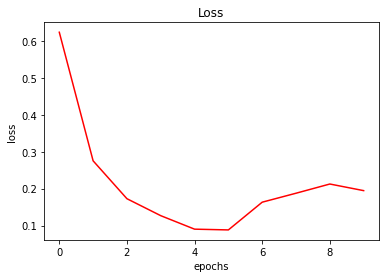

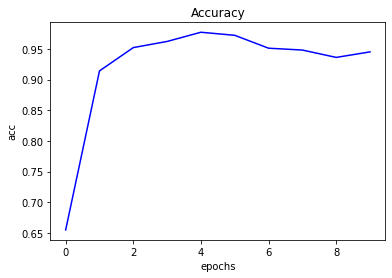

In [52]:
lr = 0.1
dataset = your_dataset
#Test using the default values (fixed) for beta and alpha 
model = FFNN(2,[4,2,1],[relu,celu,swish,softmax],2)
optimizer = SGD(list(model.parameters()), lr)
with torch.no_grad():
  loss, acc = train(model, dataset, optimizer,epochs=10,batch_size=10)
  plot_results(loss, acc)

0.754 1.5803084759414197
0.755 1.198969918638468
0.761 0.7657430194318294
0.76 0.565640804618597
0.759 0.5549801677465439
0.759 0.552185063958168
0.76 0.5499166771769524
0.761 0.5468572986125946
0.764 0.544082068502903
0.762 0.5422098842263222


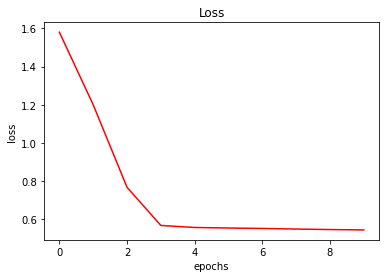

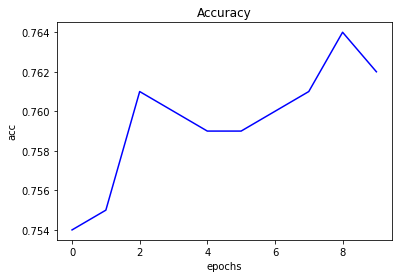

In [58]:
lr = 0.001
dataset = your_dataset
#Test using trainable values for beta and alpha 
model = FFNN(2,[1,1],[celu,swish,softmax],2,extra=[1.0,2.0,None])
optimizer = SGD(list(model.parameters()), lr)
with torch.no_grad():
  loss, acc = train(model, dataset, optimizer,epochs=10,batch_size=10)
  plot_results(loss, acc)

0.844 2.857222785949707
0.891 2.007854220867157
0.911 1.6394406020641328
0.905 1.7499647009372712
0.884 2.13679900765419
0.879 2.228902418613434
0.893 1.971012887954712
0.884 2.136798986196518
0.881 2.192061060667038
0.893 1.971012873649597


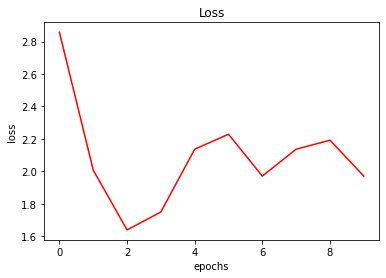

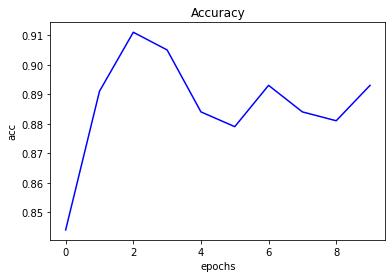

In [62]:
# using > 1 lr and single layer
lr = 3
dataset = your_dataset

#Test using trainable values for beta and alpha 
model = FFNN(2,[4],[celu,softmax],2,extra=[2.0,None])
optimizer = SGD(list(model.parameters()), lr)
with torch.no_grad():
  loss, acc = train(model, dataset, optimizer,epochs=10,batch_size=10)
  plot_results(loss, acc)

## 4e) Training using MNIST dataset in trainable mode

In [63]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor


# Downloading and storing MNIST dataset in trainable mode.
dataset_m = MNIST('mnist', train=True, transform=ToTensor(), download=True)
print('Total data:',len(dataset_m))

Total data: 60000


In [64]:
# this is the collate_fn will be use to apply the needed transformations to our input
# also we need to transform our class scalar to one-hot vector

def custom_collate(batch):
  x_data = [x[0].view(28*28) for x in batch ]

  y_data = []

  for t in batch:
    ct = torch.zeros(10)
    ct[t[1]] = 1
    y_data.append(ct)
  return torch.stack(x_data),torch.stack(y_data)

In [65]:
lr = 0.01
dataset = dataset_m
model = FFNN(784,[32,16],[celu,swish,softmax],10)
optimizer = SGD(list(model.parameters()), lr)
with torch.no_grad():
  loss, acc = train(model, dataset, optimizer,epochs=10,batch_size=100,collate=custom_collate)


0.20016666666666666 3.468949151436488
0.19208333333333333 2.2419752422968546
0.198 2.183111221988996
0.20531666666666668 2.144855509797732
0.21285 2.1118507287899653
0.21853333333333333 2.083959363301595
0.2248 2.0538953644037248
0.23645 2.022638626495997
0.2644666666666667 1.987115829984347
0.2829333333333333 1.9442875665426254


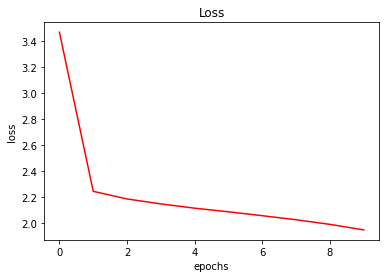

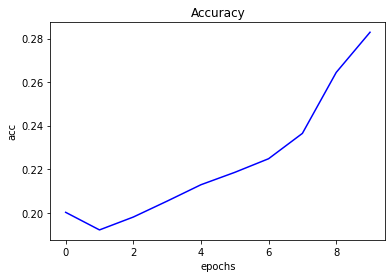

In [66]:
plot_results(loss,acc)

## Conclusions and Future work:

After going for the entire process of doing the backpropagation and calculing gradients it is much more easy to understand what can be happening at low level in one of our models. It is also valuable the understanding of the `loss` functions and how they affect the entire performance of our experiments.

Regarding future work and improvements:
* Implement the network without splitting the layers between output and hidden but handling the output one as `layers[-1]` this will result in a more compact version of the network class.

* Extend the way we are handling extra params to be able to accept activatin functions with more than one parameter or even higher dimensional parameters.

* Test with different activation functions

* Implement a different optimizer like `adam` or any variation of it.

* Code cleaning from the first task like replacing any `matmul` operation by @
